In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from argparse import ArgumentParser
from torchsummary import summary

In [2]:
data = np.load("modelnet10.npz", allow_pickle=True)
train_voxel = data["train_voxel"]  # Training 3D voxel samples
test_voxel = data["test_voxel"]  # Test 3D voxel samples
train_labels = data["train_labels"]  # Training labels (integers from 0 to 9)
test_labels = data["test_labels"]  # Test labels (integers from 0 to 9)
class_map = data["class_map"]  # Dictionary mapping the labels to their class names.

In [3]:
# Helper functions

# Plot the voxels
def plot_voxels(voxels, threshold=0.5):
    n = len(voxels)
    n_rows = (n + 1) // 2  # Calculate the number of rows needed for the given number of voxels

    fig = plt.figure(figsize=(10, 5 * n_rows))

    for idx, voxel in enumerate(voxels):
        binary_voxel = voxel > threshold
        ax = fig.add_subplot(n_rows, 2, idx + 1, projection="3d")
        ax.voxels(binary_voxel)
        ax.set_title(f'Voxel {idx + 1}')

    plt.tight_layout()
    plt.show()


# Count the number of correct predictions
def count_correct_predictions(
    predictions: torch.Tensor, threshold: float, is_greater=True
):
    if is_greater:
        return torch.sum(predictions > threshold).float().sum()
    else:
        return torch.sum(predictions < threshold).float().sum()

In [4]:
class Generator(torch.nn.Module):
    # Function from web: [https://github.com/black0017/3D-GAN-pytorch/blob/master/models/GAN3D.py]
    def __init__(
        self,
        in_channels=512,
        out_dim=64,
        out_channels=1,
        noise_dim=200,
        activation="sigmoid",
    ):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.in_dim = int(out_dim / 16)
        conv1_out_channels = int(self.in_channels / 2.0)
        conv2_out_channels = int(conv1_out_channels / 2)
        conv3_out_channels = int(conv2_out_channels / 2)

        self.linear = torch.nn.Linear(
            noise_dim, in_channels * self.in_dim * self.in_dim * self.in_dim
        )

        self.conv1 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=in_channels,
                out_channels=conv1_out_channels,
                kernel_size=(4, 4, 4),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(conv1_out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv1_out_channels,
                out_channels=conv2_out_channels,
                kernel_size=(4, 4, 4),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(conv2_out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv2_out_channels,
                out_channels=conv3_out_channels,
                kernel_size=(4, 4, 4),
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(conv3_out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv3_out_channels,
                out_channels=out_channels,
                kernel_size=(4, 4, 4),
                stride=2,
                padding=1,
                bias=False,
            )
        )
        if activation == "sigmoid":
            self.out = torch.nn.Sigmoid()
        else:
            self.out = torch.nn.Tanh()

    def project(self, x):
        """
        projects and reshapes latent vector to starting volume
        :param x: latent vector
        :return: starting volume
        """
        return x.view(-1, self.in_channels, self.in_dim, self.in_dim, self.in_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.project(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)

In [5]:
class Discriminator(torch.nn.Module):
    # Function code based on: [https://github.com/black0017/3D-GAN-pytorch/blob/master/models/GAN3D.py]
    def __init__(self, in_channels=1, dim=64, out_conv_channels=512):
        super(Discriminator, self).__init__()
        conv1_channels = int(out_conv_channels / 8)
        conv2_channels = int(out_conv_channels / 4)
        conv3_channels = int(out_conv_channels / 2)
        self.out_conv_channels = out_conv_channels
        self.out_dim = int(dim / 16)

        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels,
                out_channels=conv1_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv1_channels,
                out_channels=conv2_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv2_channels,
                out_channels=conv3_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv3_channels,
                out_channels=out_conv_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm3d(out_conv_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.out = nn.Sequential(
            nn.Linear(
                out_conv_channels * self.out_dim * self.out_dim * self.out_dim, 1
            ),
            nn.Sigmoid(),
        )

    def get_representation(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        # Create max pooling layers
        maxpool2 = nn.MaxPool3d(kernel_size=8)
        maxpool3 = nn.MaxPool3d(kernel_size=4)
        maxpool4 = nn.MaxPool3d(kernel_size=2)

        # Apply max pooling
        pooled_conv2 = maxpool2(conv2)
        pooled_conv3 = maxpool3(conv3)
        pooled_conv4 = maxpool4(conv4)

        # Concatenate along channels
        concatenated_features = torch.cat(
            [pooled_conv2, pooled_conv3, pooled_conv4], dim=1
        )

        # Flatten the concatenated features
        features = concatenated_features.view(concatenated_features.size(0), -1)

        return features

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply linear + sigmoid
        x = x.view(
            -1, self.out_conv_channels * self.out_dim * self.out_dim * self.out_dim
        )
        x = self.out(x)
        return x

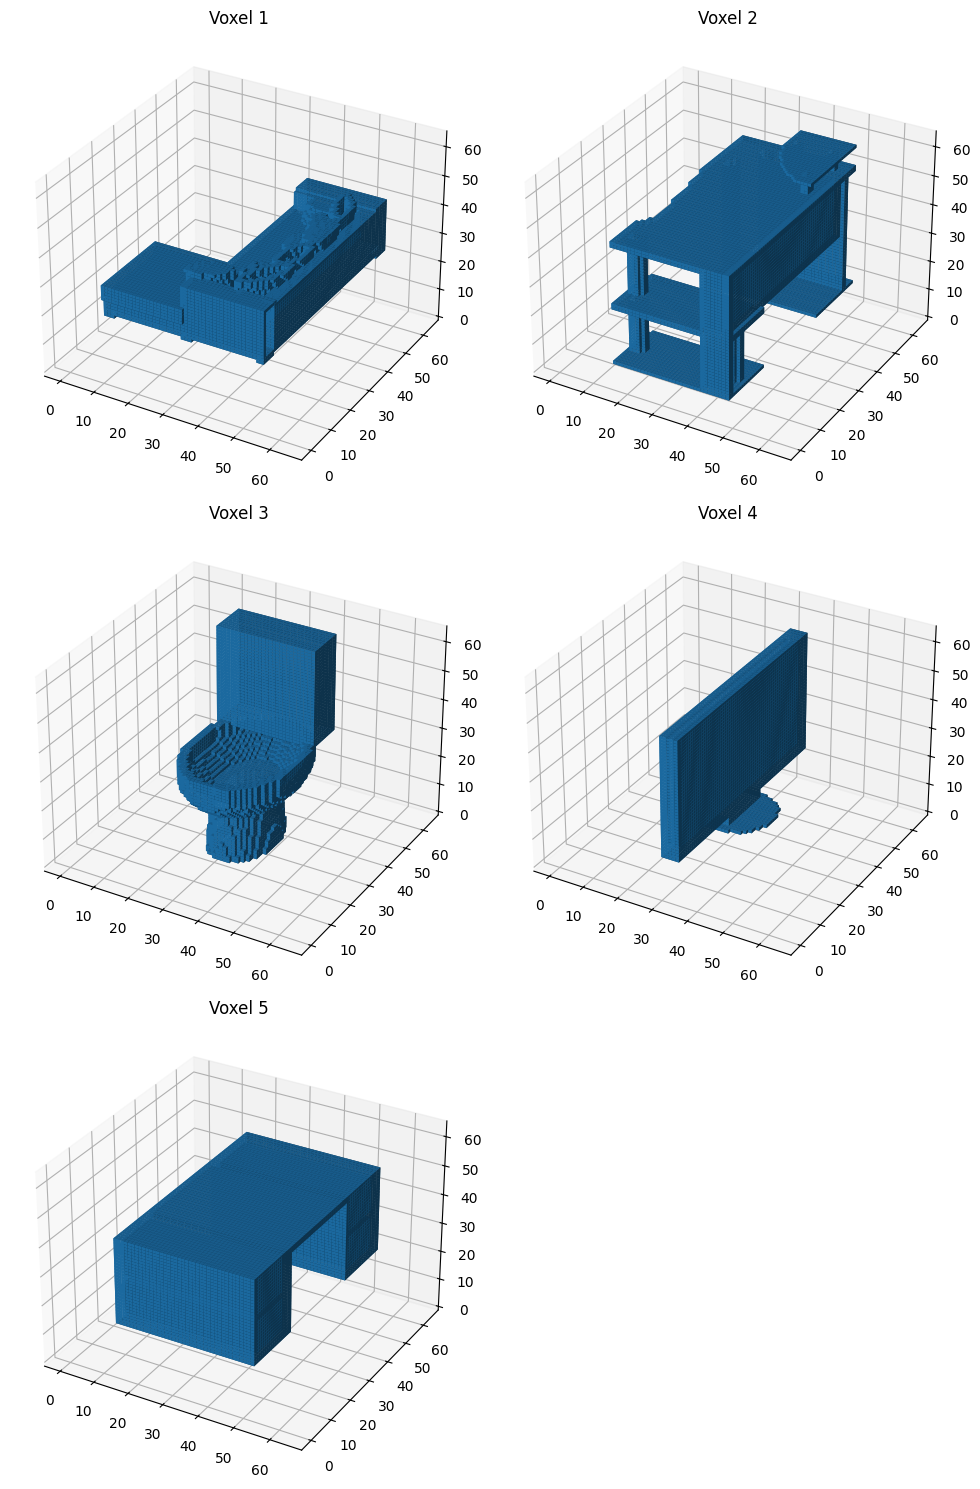

In [6]:
# Task A: Show 5 samples from the dataset

random_index = [np.random.randint(0, len(train_voxel)) for _ in range(5)]
plot_voxels(train_voxel[random_index])

In [7]:
class GAN3D(pl.LightningModule):
    def __init__(self, noise_dim=200, g_lr=0.0025, d_lr=1e-5, b1=0.5, b2=0.999):
        super(GAN3D, self).__init__()

        # Set up model with parameters
        self.noise_dim = noise_dim
        self.generator = Generator(noise_dim=noise_dim)
        self.discriminator = Discriminator()
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.b1 = b1
        self.b2 = b2
        self.loss = nn.BCELoss()
        self.automatic_optimization = False

        # For logging
        self.generator_losses = []
        self.discriminator_losses = []
        self.total_losses = []
        self.accumulated_correct = 0
        self.accumulated_number_of_samples = 0

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return self.loss(y_hat, y)

    def training_step(self, batch, batch_idx):
        imgs = batch
        imgs = imgs.to(self.device)
        opt_g, opt_d = self.optimizers()

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(self.device)
        fake = torch.zeros(imgs.size(0), 1).to(self.device)

        # Generate a batch of images
        z = torch.randn(imgs.shape[0], self.noise_dim).to(self.device)
        generated_imgs = self(z)

        # Train Generator
        discriminator_generated_imgs = self.discriminator(generated_imgs)
        g_loss = self.adversarial_loss(discriminator_generated_imgs, valid)
        g_loss.backward()
        opt_g.step()
        opt_g.zero_grad()

        # Calculate discriminator accuracy
        real_preds = self.discriminator(imgs)
        fake_preds = self.discriminator(generated_imgs.detach())
        correct_real = count_correct_predictions(real_preds, 0.5, is_greater=True)
        correct_fake = count_correct_predictions(fake_preds, 0.5, is_greater=False)
        total_correct = correct_real + correct_fake
        accuracy = total_correct / (2 * imgs.size(0))

        self.accumulated_correct += correct_real + correct_fake
        self.accumulated_number_of_samples += imgs.size(0)

        # Calculate discriminator loss
        opt_d.zero_grad()
        real_loss = self.adversarial_loss(real_preds, valid)
        fake_loss = self.adversarial_loss(fake_preds, fake)
        d_loss = (real_loss + fake_loss) / 2

        # Train Discriminator conditionally
        if not hasattr(self, "last_acc") or self.last_acc <= 0.8:
            d_loss.backward()
            opt_d.step()

        # Store current accuracy for next batch
        self.last_acc = accuracy

        # Log in tensorboard
        self.log("g_loss", g_loss)
        self.log("d_loss", d_loss)
        loss = (g_loss + d_loss) / 2
        self.log("loss", loss)
        self.generator_losses.append(g_loss.item())
        self.discriminator_losses.append(d_loss.item())
        self.total_losses.append(loss.item())

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(
            self.generator.parameters(), lr=self.g_lr, betas=(self.b1, self.b2)
        )
        opt_d = torch.optim.Adam(
            self.discriminator.parameters(), lr=self.d_lr, betas=(self.b1, self.b2)
        )
        return [opt_g, opt_d], []

    def on_train_epoch_end(self):
        self.log(
            "Total correct",
            (self.accumulated_correct) / (self.accumulated_number_of_samples * 2),
        )
        self.accumulated_correct = 0
        self.accumulated_number_of_samples = 0

    def plot_losses(self):
        plt.figure(figsize=(10, 10))

        # Plot Generator Loss
        plt.subplot(2, 2, 1)  # 1 row, 3 columns, 1st plot
        plt.plot(self.generator_losses, label="Generator Loss", color="blue")
        plt.title("Generator Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot Discriminator Loss
        plt.subplot(2, 2, 2)  # 1 row, 3 columns, 2nd plot
        plt.plot(self.discriminator_losses, label="Discriminator Loss", color="red")
        plt.title("Discriminator Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot Total Loss
        plt.subplot(2, 2, 3)  # 1 row, 3 columns, 3rd plot
        plt.plot(self.total_losses, label="Total Loss", color="green")
        plt.title("Total Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.legend()

        # Display the plots
        plt.tight_layout()
        plt.show()

In [8]:
class LinearClassifier(pl.LightningModule):
    def __init__(self, lr=1e-3, discriminator=None, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.discriminator = discriminator
        self.lr = lr
        # Instantiate linear layer, calculate input size from discriminator
        self.linear = nn.Linear(
            discriminator.get_representation(torch.randn(1, 1, 64, 64, 64)).shape[1],
            num_classes,
        )
        self.loss = nn.CrossEntropyLoss()
        self.automatic_optimization = False

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device).long()

        opt = self.optimizers()

        # Get features from discriminator
        features = self.discriminator.get_representation(x)

        logits = self(features.detach())
        loss = self.loss(logits, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        self.log("train_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device).long()

        # Get features from discriminator
        features = self.discriminator.get_representation(x)

        logits = self(features)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device).long()

        # Get features from discriminator
        features = self.discriminator.get_representation(x)

        logits = self(features)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [9]:
# Custom dataset

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Transformations to be applied on the data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.float()),  # Convert tensor to float type
        transforms.Lambda(
            lambda x: x.unsqueeze(0) if len(x.shape) == 3 else x
        ),  # Add channel dimension
    ]
)


# Create datasets
class VoxelDataset(Dataset):
    def __init__(self, data, label, if_label=False, transform=None, desired_label=None):
        self.if_label = if_label
        if desired_label is not None:
            indices = [i for i, l in enumerate(label) if l == desired_label]
            self.data = [data[i] for i in indices]
            self.label = [label[i] for i in indices]
        else:
            self.data = data
            self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        voxel = self.data[index]

        if self.transform:
            voxel = self.transform(voxel)

        if self.if_label:
            return voxel, self.label[index]

        return voxel

In [10]:
# Create config for parameters
parser = ArgumentParser(description="3D GAN")

parser.add_argument("--batch_size", type=int, default=100)
parser.add_argument("--epochs", type=int, default=10)
parser.add_argument("--g_lr", type=float, default=0.0025)
parser.add_argument("--d_lr", type=float, default=1e-4)
parser.add_argument("--b1", type=float, default=0.5)
parser.add_argument("--b2", type=float, default=0.999)
parser.add_argument("--noise_dim", type=int, default=200)
parser.add_argument("--classifier_lr", type=float, default=1e-3)
parser.add_argument("--classifier_epochs", type=int, default=10)
parser.add_argument("--desired_label", type=int, default=None)

args = parser.parse_args(args=[])

In [11]:
# Train the 3DGAN

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
train_dataset = VoxelDataset(
    train_voxel,
    train_labels,
    transform=transform,
    desired_label=args.desired_label,
    if_label=False,
)

# DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True
)

# Initialize the GAN
model = GAN3D(
    d_lr=args.d_lr, g_lr=args.g_lr, noise_dim=args.noise_dim, b1=args.b1, b2=args.b2
)
model = model.to(device)

# Set logger
tb_logger = TensorBoardLogger(
    "logs/",
    name="GAN3D",
    version="3DGAN_epochs={}_label={}.pt".format(args.epochs, args.desired_label),
)

# Initialize the Trainer
trainer = pl.Trainer(max_epochs=args.epochs, accelerator="gpu", logger=tb_logger)

# Train the model
trainer.fit(
    model,
    train_loader,
    ckpt_path=None,
)

# Task A: Save trained model for later use
torch.save(
    {"model_state_dict": model.state_dict(), "config": vars(args)},
    "3DGAN_epochs={}_label={}.pt".format(args.epochs, args.desired_label),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 17.6 M
1 | discriminator | Discriminator | 11.0 M
2 | loss          | BCELoss       | 0     
------------------------------------------------
28.7 M    Trainable params
0         Non-trainable params
28.7 M    Total params
114.601   Total estimated model params size (MB)
/home/vebjo/3D_GAN/ACIT-4030/.venv/lib/python3.10/site-

Epoch 9: 100%|██████████| 39/39 [00:48<00:00,  1.24s/it, v_num=e.pt]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 39/39 [00:48<00:00,  1.26s/it, v_num=e.pt]


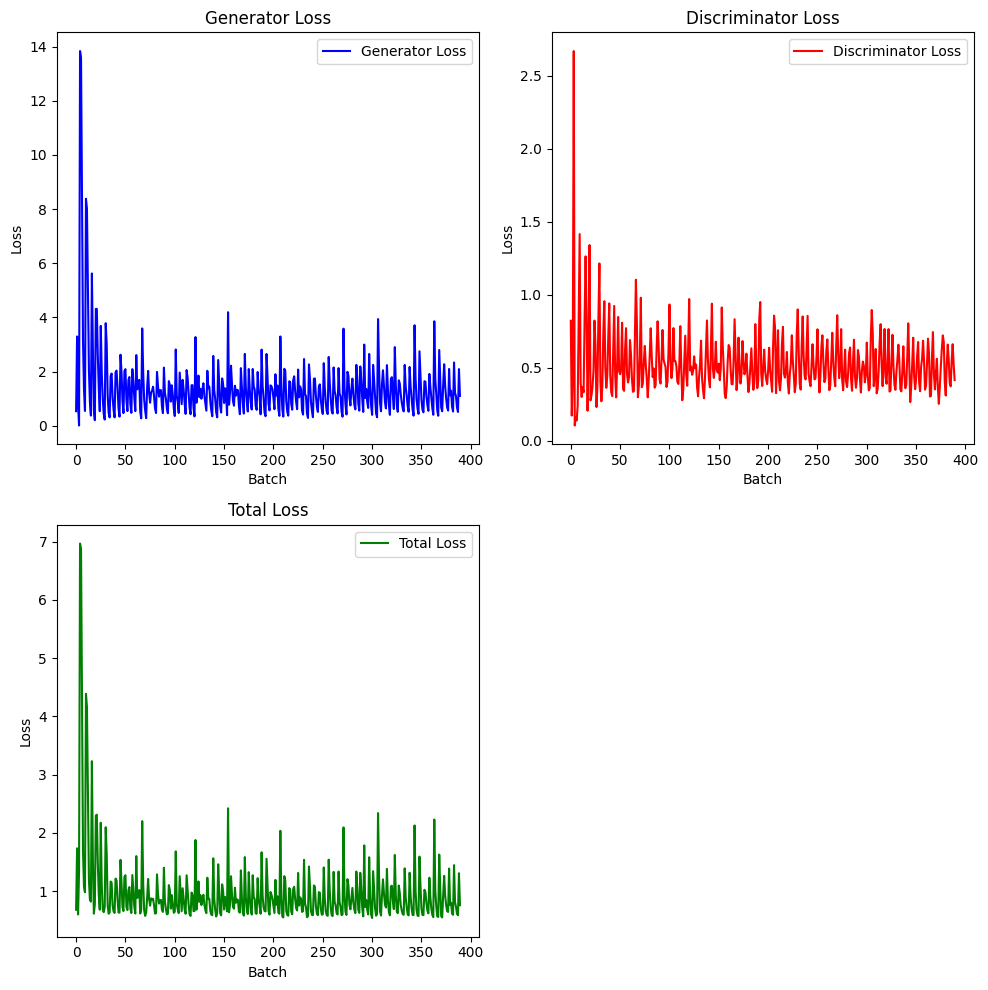

In [12]:
# Task A: Present a figure of the history of the training loss of the discriminator and generator.
model.plot_losses()

In [13]:
# Task A: Show the total number of parameters of the two models.

model = model.to(device)

# Generator
print("Number of parameters in Generator:")
summary(model, (1, 200))

# Discriminator
print("Number of parameters in Discriminator:")
summary(model.discriminator, (1, 64, 64, 64))

Number of parameters in Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 32768]       6,586,368
   ConvTranspose3d-2         [-1, 256, 8, 8, 8]       8,388,608
       BatchNorm3d-3         [-1, 256, 8, 8, 8]             512
              ReLU-4         [-1, 256, 8, 8, 8]               0
   ConvTranspose3d-5      [-1, 128, 16, 16, 16]       2,097,152
       BatchNorm3d-6      [-1, 128, 16, 16, 16]             256
              ReLU-7      [-1, 128, 16, 16, 16]               0
   ConvTranspose3d-8       [-1, 64, 32, 32, 32]         524,288
       BatchNorm3d-9       [-1, 64, 32, 32, 32]             128
             ReLU-10       [-1, 64, 32, 32, 32]               0
  ConvTranspose3d-11        [-1, 1, 64, 64, 64]           4,096
          Sigmoid-12        [-1, 1, 64, 64, 64]               0
        Generator-13        [-1, 1, 64, 64, 64]               0
Tota

In [14]:
# Train the classifier

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load 3DGAN model
model = GAN3D(
    d_lr=args.d_lr, g_lr=args.g_lr, noise_dim=args.noise_dim, b1=args.b1, b2=args.b2
)
model.load_state_dict(
    torch.load("3DGAN_epochs={}_label={}.pt".format(args.epochs, args.desired_label))[
        "model_state_dict"
    ]
)

# Initialize the classifier
classifier = LinearClassifier(lr=args.classifier_lr, discriminator=model.discriminator)
classifier = classifier.to(device)

# Dataset
train_dataset = VoxelDataset(
    train_voxel,
    train_labels,
    transform=transform,
    desired_label=args.desired_label,
    if_label=True,
)
test_dataset = VoxelDataset(
    test_voxel,
    test_labels,
    transform=transform,
    desired_label=args.desired_label,
    if_label=True,
)

# Split test dataset into train and validation
test_size = int(0.8 * len(test_dataset))
val_size = len(test_dataset) - test_size
test_dataset, val_dataset = torch.utils.data.random_split(
    test_dataset, [test_size, val_size]
)

# Load validation data
train_loader = DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True
)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

# Set logger
tb_logger = TensorBoardLogger(
    "logs/",
    name="LinearClassifier",
    version="Classifier_epochs={}_3DGAN_epochs={}_label={}".format(
        args.classifier_epochs, args.epochs, args.desired_label
    ),
)

# Initialize the Trainer
trainer = pl.Trainer(
    max_epochs=args.classifier_epochs, accelerator="gpu", logger=tb_logger
)

# Train the model
trainer.fit(classifier, train_loader, val_dataloaders=val_loader)

# Test the model
trainer.test(classifier, test_loader)

# Save model
torch.save(
    {"model_state_dict": classifier.state_dict(), "config": vars(args)},
    "Classifier_epochs={}_3DGAN_epochs={}.pt".format(
        args.classifier_epochs, args.epochs
    ),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | discriminator | Discriminator    | 11.0 M
1 | linear        | Linear           | 71.7 K
2 | loss          | CrossEntropyLoss | 0     
---------------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.482    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/vebjo/3D_GAN/ACIT-4030/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 39/39 [00:06<00:00,  6.36it/s, v_num=None]       

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 39/39 [00:06<00:00,  6.28it/s, v_num=None]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/vebjo/3D_GAN/ACIT-4030/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00,  8.07it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8732782602310181     │
│         test_loss         │    0.5207211971282959     │
└───────────────────────────┴───────────────────────────┘

In [15]:
# Task B: Show the total number of parameters of the classifier.

z = model.discriminator.get_representation(torch.randn(1, 1, 64, 64, 64))
z = z.to(device)
classifier = classifier.to(device)
print("Number of parameters in Classifier:")
summary(classifier, z.shape)

Number of parameters in Classifier:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]          71,690
Total params: 71,690
Trainable params: 71,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.27
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


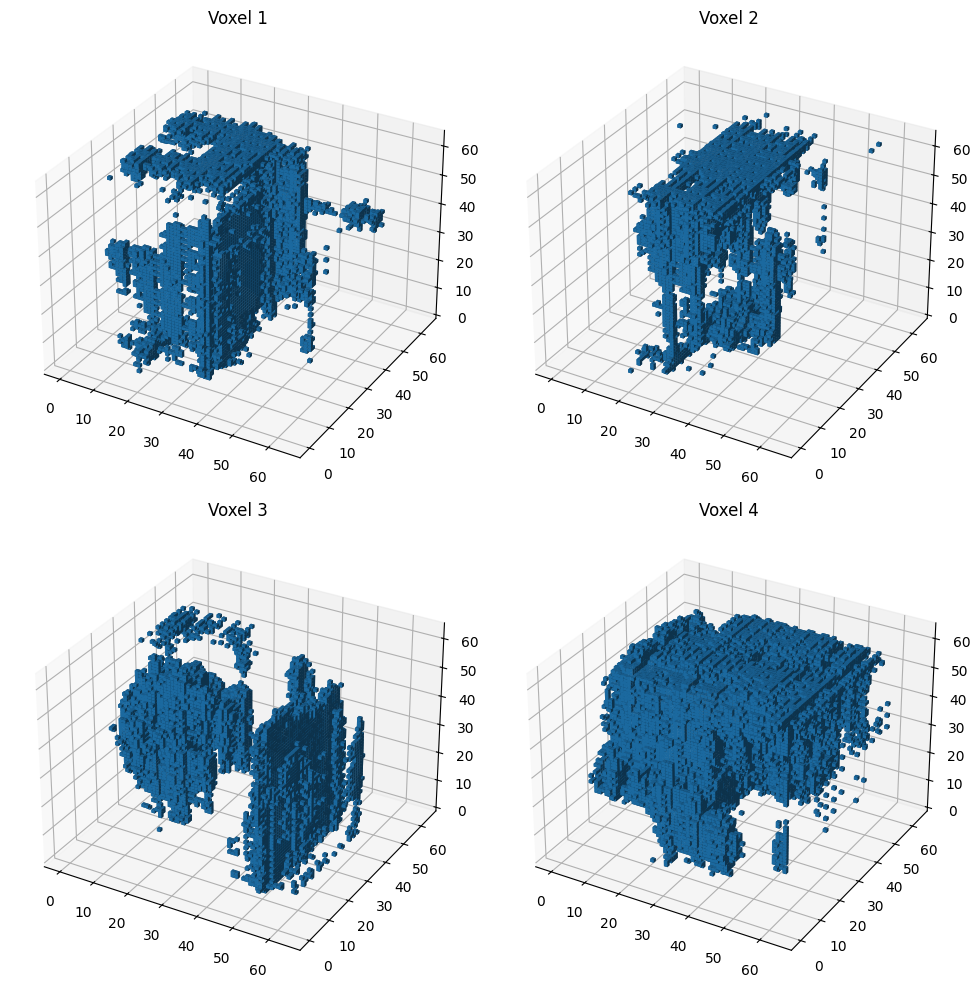

In [16]:
# Task A: Show 4 generated 3D voxel data using the trained generator model with different latent vector z.

model = GAN3D()
model.load_state_dict(
    torch.load("3DGAN_epochs={}_label={}.pt".format(args.epochs, args.desired_label))[
        "model_state_dict"
    ]
)
number_of_samples = 4
z = torch.randn(number_of_samples, 200)
generated_imgs = model(z)

plot_voxels(generated_imgs.detach().cpu().numpy().squeeze(), threshold=0.5)